D2L Sec 9.1 Time Series Prediction Example

In [1]:
%%capture
# capture the standard out to keep the screen uncluttered
!pip install d2l==1.0.0-alpha1.post0

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(**Here, our 1000 synthetic data will follow
the trigonometric `sin` function,
applied to 0.01 times the time step.
To make the problem a little more interesting,
we corrupt each sample with additive noise.**)
From this sequence we extract training examples,
each consisting of features and a label.


**Time Series:**  $\{x_t; 1 \le t \le T\}$, $x_t = sin(0.01*t) + 0.2\epsilon_t$ where $\epsilon_t \in N(0,1), i.i.d.$ \\
$T = 1000$. Training data indices: $\{1 \le t \le 600\}$, the remaining are testing data. \\
**Time Series Model:** $y_t = \sum_{i=1}^\tau a_i x_{t-i}$, $\tau = 4$.

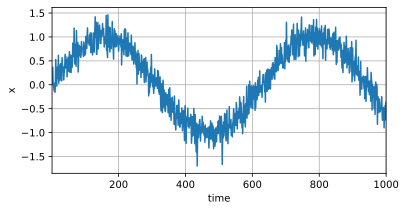

In [3]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = tf.range(1, T + 1, dtype=tf.float32)
        self.x = tf.sin(0.01 * self.time) + tf.random.normal([T]) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as though
the data satisfied a $\tau$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations.
[**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]
The astute reader might have noticed that
this results in $1000-\tau$ examples,
since we lack sufficient history for $y_1, \ldots, y_\tau$.
While we could pad the first $\tau$ sequences with zeros,
to keep things simple, we drop them for now.
The resulting dataset contains $T - \tau$ examples,
where each input to the model has sequence length $\tau$.
We (**create a data iterator on the first 600 examples**),
covering a period of the sin function.


To fit the training data into the time series model, we will pack the time series data into feature vectors, and stack them into a feature matrix \\
\begin{equation} \left[ \matrix{x_0 & x_1 & x_2 & x_3 \\ x_1 & x_2 & x_3 & x_4 \\ \vdots & \vdots & \vdots & \vdots \\x_{596} & x_{597} & x_{598} & x_{599}} \right] \left[ \matrix{a_4 \\ a_3\\ a_2 \\ a_1} \right] = \left[ \matrix{y_4 \\ y_5 \\ \vdots \\ y_{600}} \right] \end{equation}
The testing data can also be formulated in the same way into a testing feature matrix. \\
If the square loss function is used, the ${\bf a}$ coefficient vector may be estimated using the least square training. For data adaptive training, the mini-batch size is chosen as 16. Note that rows in the training feature matrix may be shuffled for each epoch.

In [4]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = tf.stack(features, 1)
    self.labels = tf.reshape(self.x[self.tau:], (-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a standard linear regression.


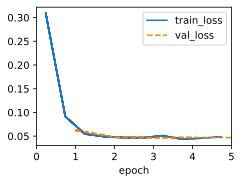

In [5]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

## Prediction

[**To evaluate our model, we first check
how well our model performs at one-step-ahead prediction**].


With *one-step-ahead* prediction, $y_t = \hat{x}_t$.

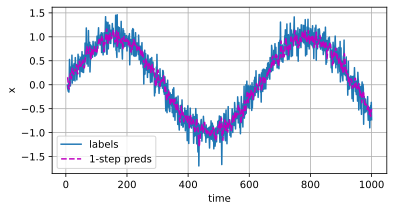

In [6]:
onestep_preds = model(data.features).numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

The one-step-ahead predictions look good,
even near the end $t=1000$.

Now consider, what if we only observed sequence data
up until time step 604 (`n_train + tau`)
but wished to make predictions several steps
into the future.
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [7]:
multistep_preds = tf.Variable(tf.zeros(data.T))
multistep_preds[:].assign(data.x)
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i].assign(tf.reshape(model(
        tf.reshape(multistep_preds[i-data.tau : i], (1, -1))), ()))

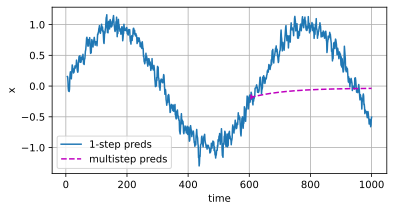

In [8]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few prediction steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this owes to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.


**Note:** The discussion above assumes that one wants to use a one-step prediction model as developed above for multi-step (>1) prediction. As such, one has to substitute predicted time series values as if they were observed to facilitate multiple step prediction. \\
Alternatively, given the fixed number of steps $k$, one may designate $y_t = x_{t+k-1}$ in the least square training equation above and train a *k-step* prediction model directly. This is shown below.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.

In [9]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(tf.stack(features[i : i+data.tau], 1))
        features.append(tf.reshape(preds, -1))
    return features[data.tau:]

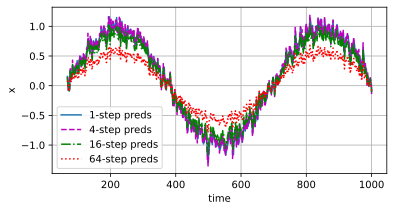

In [10]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))